# API Key

In [1]:
import os
from tqdm import tqdm
from IPython.display import Image, display #LangGraph圖表展示

os.environ["GOOGLE_API_KEY"] = ''

# 資料庫記憶

In [2]:
import time
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

class OverallState(TypedDict):
    """State representing the customer's order conversation."""

    # The chat conversation. This preserves the conversation history
    # between nodes. The `add_messages` annotation indicates to LangGraph
    # that state is updated by appending returned messages, not replacing
    # them.
    messages: Annotated[list, add_messages]
    time_in_seconeds : int
    # Flag indicating that the order is placed and completed.
    finished: bool

        
class TimerState(TypedDict):
    timer_duration : int
    timer_done : bool
    response_message : str
        

# 使用語言模型

In [3]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI

# Try using different models. The `pro` models perform the best, especially
# with tool-calling. The `flash` models are super fast, and are a good choice
# if you need to use the higher free-tier quota.
# Check out the features and quota differences here: https://ai.google.dev/pricing
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest")


# ChatBot Node

In [4]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph.message import add_messages

In [13]:
from langchain_core.messages.ai import AIMessage
TIMERBOT_SYSINT = (
    "system",  # 'system' indicates the message is a system instruction.
    "你是一個TimerBot 用來為使用者計時"
    "在過程中，你將全程使用中文回答問題"
    "使用者會和你談論你所擁有的功能，你將誠實回答有關擁有功能的所有問題"
    "使用者會要求設置計時器，您將開啟計時器"
    "\n\n"
    "使用 start_timer 以開啟計時器"
    "使用 pause_timer 以暫停計時器"
    "使用 close_timer 以關閉計時器"
)

WELCOME_MSG = "歡迎使用計時器，按下'q'以離開"


def chatbot_node(state: OverallState) -> OverallState:
    """聊天機器人本體，包裝了簡易UI設置與初始化說明以及歡迎訊息"""
    defaults = {"finished": False, "time_in_seconds": 20}

    if state["messages"]:
        new_output = llm_with_tools.invoke([TIMERBOT_SYSINT] + state["messages"])
    else:
        new_output = AIMessage(content=WELCOME_MSG)

    # Set up some defaults if not already set, then pass through the provided state,
    # overriding only the "messages" field.
    return defaults | state | {"messages": [new_output]}


# Human Node

In [6]:
def human_node(state: OverallState) -> OverallState:
    """
    將最後一個模型訊息顯示給使用者，並接收使用者訊息
    如果使用者輸入q 則會改變state['finished']裡的值，
    在離開的判斷中走向__END__
    """
    last_msg = state["messages"][-1]
    print("Model:", last_msg.content)

    user_input = input("User: ")

    # If it looks like the user is trying to quit, flag the conversation
    # as over.
    if user_input in {"q", "quit", "exit", "goodbye", "bye"}:
        state["finished"] = True

    return state | {"messages": [("user", user_input)]}


from typing import Literal


def maybe_exit_human_node(state: OverallState) -> Literal["chatbot", "__end__"]:
    """從human_node結束後的下一個節點方向決策"""
    if state.get("finished", False):
        return END
    else:
        return "chatbot"



# 工具區域

In [7]:
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool

In [9]:
import threading
import tkinter as tk
from tkinter import messagebox
from time import sleep


class TimerApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Timer App")
        
        # 初始化時間和狀態
        self.time_left = 0
        self.running = False
        
        # 顯示時間的標籤
        self.timer_label = tk.Label(root, text="00:00", font=("Helvetica", 48))
        self.timer_label.pack(pady=20)

    def start_timer(self, time_in_seconds):
        if not self.running:
            self.time_left = time_in_seconds
            self.running = True
            
            # 啟動線程執行倒計時
            timer_thread = threading.Thread(target=self.countdown)
            timer_thread.daemon = True  # 保證主程式結束時該線程也會結束
            timer_thread.start()

    def countdown(self):
        while self.time_left > 0 and self.running:
            minutes, seconds = divmod(self.time_left, 60)
            self.timer_label.config(text=f"{minutes:02}:{seconds:02}")
            sleep(1)  # 每秒減少 1
            self.time_left -= 1

        if self.time_left == 0 and self.running:
            self.running = False
            self.timer_label.config(text="00:00")
            # messagebox.showinfo("Timer Done", "Time's up!")

# 定義工具函式
@tool
def start_timer(time_in_seconds: int) -> str:
    """開始運行計時器，
    
    參數:
    - time_in_seconds: 計時器的秒數。
    """
    root = tk.Tk()
    app = TimerApp(root)
    
    # 自動開始計時
    app.start_timer(time_in_seconds)
    
    # 啟動 Tkinter 事件循環
    root.mainloop()
    return f"Timer started for {time_in_seconds} seconds!"

# 整包線程 timer

In [20]:
import tkinter as tk
import threading
from time import sleep
from langchain_core.tools import tool

class TimerApp:
    def __init__(self, root, callback):
        self.root = root
        self.root.title("Timer App")
        
        # 初始化時間和狀態
        self.time_left = 0
        self.running = False
        self.callback = callback
        self.time_in_seconds = 0
        
        # 顯示時間的標籤
        self.timer_label = tk.Label(root, text="00:00", font=("Helvetica", 48))
        self.timer_label.pack(pady=20)

    def start_timer(self, time_in_seconds):
        if not self.running:
            self.time_in_seconds = time_in_seconds
            self.time_left = time_in_seconds
            self.running = True
            
            # 傳遞計時開始訊息
            # self.callback(f"Timer started for {time_in_seconds} seconds.")
            
            # 啟動線程執行倒計時
            timer_thread = threading.Thread(target=self.countdown)
            timer_thread.daemon = True  # 保證主程式結束時該線程也會結束
            timer_thread.start()

    def countdown(self):
        while self.time_left > 0 and self.running:
            minutes, seconds = divmod(self.time_left, 60)
            self.timer_label.config(text=f"{minutes:02}:{seconds:02}")
            sleep(1)  # 每秒減少 1
            self.time_left -= 1

        if self.time_left == 0 and self.running:
            self.running = False
            self.timer_label.config(text="00:00")
            
            # 傳遞計時結束訊息
            self.callback(f"Model: 計時 {self.time_in_seconds}秒時間到！")



@tool
def start_timer(time_in_seconds: int) -> str:
    """開始運行計時器，
    
    參數:
    - time_in_seconds: 計時器的秒數。
    """
    
    def callback(message):
        print(message)  # 回調函數處理計時開始與結束的結果
    
    def run_timer_app():
        root = tk.Tk()
        app = TimerApp(root, callback)
        
        # 自動開始計時
        app.start_timer(time_in_seconds)
        
        # 啟動 Tkinter 事件循環
        root.mainloop()

    # 把計時器運行放入單獨的線程
    timer_thread = threading.Thread(target=run_timer_app)
    timer_thread.daemon = True  # 保證主程式結束時該線程也會結束
    timer_thread.start()

    return f"Timer started for {time_in_seconds} seconds!"


# 整包線程 加入關閉 timer

In [24]:
import tkinter as tk
import threading
from time import sleep
from langchain_core.tools import tool

# 全局變數用於存儲計時器實例
active_timer = None

class TimerApp:
    def __init__(self, root, callback):
        self.root = root
        self.root.title("Timer App")
        
        # 初始化時間和狀態
        self.time_left = 0
        self.running = False
        self.callback = callback
        self.time_in_seconds = 0
        
        # 顯示時間的標籤
        self.timer_label = tk.Label(root, text="00:00", font=("Helvetica", 48))
        self.timer_label.pack(pady=20)

    def start_timer(self, time_in_seconds):
        if not self.running:
            self.time_in_seconds = time_in_seconds
            self.time_left = time_in_seconds
            self.running = True
            
            # 啟動線程執行倒計時
            timer_thread = threading.Thread(target=self.countdown)
            timer_thread.daemon = True  # 保證主程式結束時該線程也會結束
            timer_thread.start()

    def countdown(self):
        while self.time_left > 0 and self.running:
            minutes, seconds = divmod(self.time_left, 60)
            self.timer_label.config(text=f"{minutes:02}:{seconds:02}")
            sleep(1)  # 每秒減少 1
            self.time_left -= 1

        if self.time_left == 0 and self.running:
            self.running = False
            self.timer_label.config(text="00:00")
            self.callback(f"Model: 計時 {self.time_in_seconds}秒時間到！")

    def stop_timer(self):
        """停止計時器"""
        if self.running:
            self.running = False
            self.callback("Model: 計時器已關閉。")
            self.root.destroy()  # 關閉 Tkinter 視窗


@tool
def start_timer(time_in_seconds: int) -> str:
    """開始運行計時器，並返回結果。

    參數:
    - time_in_seconds: 計時器的秒數。
    """
    global active_timer  # 使用全局變數存儲計時器

    def callback(message):
        print(message)  # 回調函數處理計時開始與結束的結果
    
    def run_timer_app():
        root = tk.Tk()
        app = TimerApp(root, callback)
        global active_timer
        active_timer = app  # 存儲當前計時器實例
        
        # 自動開始計時
        app.start_timer(time_in_seconds)
        
        # 啟動 Tkinter 事件循環
        root.mainloop()

    # 把計時器運行放入單獨的線程
    timer_thread = threading.Thread(target=run_timer_app)
    timer_thread.daemon = True  # 保證主程式結束時該線程也會結束
    timer_thread.start()

    return f"Timer started for {time_in_seconds} seconds!"


@tool
def close_timer() -> str:
    """關閉當前正在運行的計時器。"""
    global active_timer
    if active_timer and active_timer.running:
        active_timer.stop_timer()
        active_timer = None  # 清空計時器實例
        return "Timer successfully closed."
    else:
        return "No active timer to close."

# 使用Application

In [56]:
import subprocess

@tool
def start_timer(time_in_seconds: int) -> str:
    """開始運行計時器，
    
    參數:
    - time_in_seconds: 計時器的秒數。
    """
    # 構造指令，使用完整路徑指定 Timer.py 檔案
    script_path = r"C:\Users\USER\Desktop\Python PJ\AI Agent\tools\Timer.py"
    
    # 使用 subprocess 執行外部 Python 檔案
    subprocess.run(["python", script_path, str(time_in_seconds)])
    
    
    return f"Timer started for {time_in_seconds} seconds!"

# 整包線程 + 暫停

In [32]:
import tkinter as tk
import threading
from time import sleep

class TimerApp:
    def __init__(self, root, callback):
        self.root = root
        self.root.title("Timer App")
        
        # 初始化時間和狀態
        self.time_left = 0
        self.running = False
        self.callback = callback
        
        # 顯示時間的標籤
        self.timer_label = tk.Label(root, text="00:00", font=("Helvetica", 48))
        self.timer_label.pack(pady=20)

    def start_timer(self, time_in_seconds):
        if not self.running:
            self.time_left = time_in_seconds
            self.running = True
            
            # 傳遞計時開始訊息
            # self.callback(f"Timer started for {time_in_seconds} seconds.")
            
            # 啟動線程執行倒計時
            timer_thread = threading.Thread(target=self.countdown)
            timer_thread.daemon = True  # 保證主程式結束時該線程也會結束
            timer_thread.start()

    def countdown(self):
        while self.time_left > 0 and self.running:
            minutes, seconds = divmod(self.time_left, 60)
            self.timer_label.config(text=f"{minutes:02}:{seconds:02}")
            sleep(1)  # 每秒減少 1
            self.time_left -= 1

        if self.time_left == 0 and self.running:
            self.running = False
            self.timer_label.config(text="00:00")
            
            # 傳遞計時結束訊息
            self.callback("Timer Done!")

    def pause_timer(self):
        """暫停計時器"""
        self.running = False
        self.callback("Timer paused.")


# Global variable to store the current TimerApp instance
current_timer_app = None

@tool
def start_timer(time_in_seconds: int) -> str:
    """開始運行計時器
    
    參數:
    - time_in_seconds: 計時器的秒數。
    """
    
    global current_timer_app

    def callback(message):
        print(message)  # 回調函數處理計時開始與結束的結果
    
    def run_timer_app():
        root = tk.Tk()
        app = TimerApp(root, callback)
        
        # 自動開始計時
        app.start_timer(time_in_seconds)
        
        # 啟動 Tkinter 事件循環
        root.mainloop()

    # 創建並啟動計時器應用
    current_timer_app = TimerApp(tk.Tk(), callback)
    current_timer_app.start_timer(time_in_seconds)
    
    return f"Timer started for {time_in_seconds} seconds!"

@tool
def pause_timer() -> str:
    """暫停計時器"""
    
    global current_timer_app
    
    if current_timer_app and current_timer_app.running:
        current_timer_app.pause_timer()
        return "Timer paused."
    else:
        return "No timer is currently running."

In [10]:
import threading
import tkinter as tk
from tkinter import messagebox
from time import sleep


class TimerApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Timer App")
        
        # 初始化時間和狀態
        self.time_left = 0
        self.running = False
        
        # 顯示時間的標籤
        self.timer_label = tk.Label(root, text="00:00", font=("Helvetica", 48))
        self.timer_label.pack(pady=20)

    def start_timer(self, time_in_seconds):
        if not self.running:
            self.time_left = time_in_seconds
            self.running = True
            
            # 啟動線程執行倒計時
            timer_thread = threading.Thread(target=self.countdown)
            timer_thread.daemon = True  # 保證主程式結束時該線程也會結束
            timer_thread.start()

    def countdown(self):
        while self.time_left > 0 and self.running:
            minutes, seconds = divmod(self.time_left, 60)
            self.timer_label.config(text=f"{minutes:02}:{seconds:02}")
            sleep(1)  # 每秒減少 1
            self.time_left -= 1

        if self.time_left == 0 and self.running:
            self.running = False
            self.timer_label.config(text="00:00")
            messagebox.showinfo("Timer Done", "Time's up!")

# 定義工具函式
#@tool
def start_timer(time_in_seconds: int) -> str:
    """開始運行計時器，
    
    參數:
    - time_in_seconds: 計時時間 以秒為單位。
    """
    root = tk.Tk()
    app = TimerApp(root)
    
    # 自動開始計時
    app.start_timer(time_in_seconds)
    
    # 啟動 Tkinter 事件循環
    root.mainloop()
    return f"Timer started for {time_in_seconds} seconds!"

In [9]:
def maybe_exit_chatbot_node(state: OverallState) -> Literal["tools", "human"]:
    """Route between human or tool nodes, depending if a tool call is made."""
    if not (msgs := state.get("messages", [])):
        raise ValueError(f"No messages found when parsing state: {state}")

    # Only route based on the last message.
    msg = msgs[-1]

    # When the chatbot returns tool_calls, route to the "tools" node.
    if hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        return "tools"
    else:
        return "human"

In [25]:
# Define the tools and create a "tools" node.
tools = [start_timer, close_timer]
tool_node = ToolNode(tools)

# Attach the tools to the model so that it knows what it can call.
llm_with_tools = llm.bind_tools(tools)

# Compile 區域

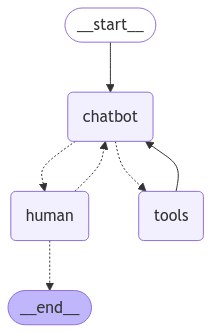

In [26]:
# Start building a new graph.
graph_builder = StateGraph(OverallState)

# Add the chatbot and human nodes to the app graph.
graph_builder.add_node("chatbot", chatbot_node)
graph_builder.add_node("human", human_node)
graph_builder.add_node("tools", tool_node)

# Start with the chatbot again.
graph_builder.add_edge(START, "chatbot")

# chatbot node完成後會自動開始 human node
# graph_builder.add_edge("chatbot", "human");
graph_builder.add_edge("tools", "chatbot")

# Chatbot may go to tools, or human.
graph_builder.add_conditional_edges("chatbot", maybe_exit_chatbot_node)
graph_builder.add_conditional_edges("human", maybe_exit_human_node)

chat_with_human_graph = graph_builder.compile()

Image(chat_with_human_graph.get_graph().draw_mermaid_png())

# 溝通區域

In [ ]:
# Remember that this will loop forever, unless you input `q`, `quit` or one of the
# other exit terms defined in `human_node`.
# Uncomment this line to execute the graph:
state = chat_with_human_graph.invoke({"messages": []})

# Things to try:
#  - Just chat! There's no ordering or menu yet.
#  - 'q' to exit.

# pprint(state)

Model: 歡迎使用計時器，按下'q'以離開
User: 計時1分鐘
Model: 好的，已為您設定 1 分鐘的計時器，請稍候。

User: 關閉計時器
Model: 計時器已關閉。


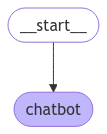

In [28]:

# The system instruction defines how the chatbot is expected to behave and includes
# rules for when to call different functions, as well as rules for the conversation, such
# as tone and what is permitted for discussion.
K_SYSINT = (
    "system",  # 'system' indicates the message is a system instruction.
    "你是一個開發中的全能的問題回覆機器人，當有人對你下達指令時，你會檢查是否支援此項詢問功能"
    "並根據已開發完成的功能予以回應,使用get_menu 來顯示選單"
    "\n\n"
    "使用import_novel 來匯入小說"
    "使用read_novel 來讀取小說"
    "當使用者的要求涉及刪除或者編輯檔案行為 使用 comfirm_edit 進行二次確認"
    "當使用者要求停止服務時，感謝使用者的使用並說再見"
)

# This is the message with which the system opens the conversation.
WELCOME_MSG = "歡迎使用全能機器人，請按'q'以離開，我可以幫助您什麼?"

def chatbot(state: OverallState) -> OverallState:
    """The chatbot itself. A simple wrapper around the model's own chat interface."""
    message_history = [K_SYSINT] + state["messages"]
    return {"messages": [llm.invoke(message_history)]}


# Set up the initial graph based on our state definition.
graph_builder = StateGraph(OverallState)

# Add the chatbot function to the app graph as a node called "chatbot".
graph_builder.add_node("chatbot", chatbot)

# Define the chatbot node as the app entrypoint.
graph_builder.add_edge(START, "chatbot")

chat_graph = graph_builder.compile()

Image(chat_graph.get_graph().draw_mermaid_png())

# 單ChatBot 測試

In [22]:
from pprint import pprint

user_msg = "你好，你可以做到什麼?"
state = chat_graph.invoke({"messages": [user_msg]})

# The state object contains lots of information. Uncomment the pprint lines to see it all.
# pprint(state)

# Note that the final state now has 2 messages. Our HumanMessage, and an additional AIMessage.
for msg in state["messages"]:
    print(f"{type(msg).__name__}: {msg.content}")

HumanMessage: 你好，你可以做到什麼?
AIMessage: 您好！ 目前我正在開發中，以下列出我已完成的功能：

```
get_menu()
```



# Human Node

In [15]:
from langchain_core.messages.ai import AIMessage


def human_node(state: OverallState) -> OverallState:
    """Display the last model message to the user, and receive the user's input."""
    last_msg = state["messages"][-1]
    print("Model:", last_msg.content)

    user_input = input("User: ")

    # If it looks like the user is trying to quit, flag the conversation
    # as over.
    if user_input in {"q", "quit", "exit", "goodbye"}:
        state["finished"] = True

    return state | {"messages": [("user", user_input)]}


def chatbot_with_welcome_msg(state: OverallState) -> OverallState:
    """The chatbot itself. A wrapper around the model's own chat interface."""

    if state["messages"]:
        # If there are messages, continue the conversation with the Gemini model.
        new_output = llm.invoke([M_SYSINT] + state["messages"])
    else:
        # If there are no messages, start with the welcome message.
        new_output = AIMessage(content=WELCOME_MSG)

    return state | {"messages": [new_output]}


# Start building a new graph.
graph_builder = StateGraph(OverallState)

# Add the chatbot and human nodes to the app graph.
graph_builder.add_node("chatbot", chatbot_with_welcome_msg)
graph_builder.add_node("human", human_node)

# Start with the chatbot again.
graph_builder.add_edge(START, "chatbot")

# The chatbot will always go to the human next.
graph_builder.add_edge("chatbot", "human");

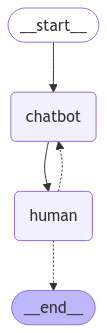

In [26]:
from typing import Literal


def maybe_exit_human_node(state: OverallState) -> Literal["chatbot", "__end__"]:
    """Route to the chatbot, unless it looks like the user is exiting."""
    if state.get("finished", False):
        return END
    else:
        return "chatbot"


graph_builder.add_conditional_edges("human", maybe_exit_human_node)

chat_with_human_graph = graph_builder.compile()

Image(chat_with_human_graph.get_graph().draw_mermaid_png())

# 測試

In [16]:
# Remember that this will loop forever, unless you input `q`, `quit` or one of the
# other exit terms defined in `human_node`.
# Uncomment this line to execute the graph:
state = chat_with_human_graph.invoke({"messages": []})

# Things to try:
#  - Just chat! There's no ordering or menu yet.
#  - 'q' to exit.

# pprint(state)

Model: 歡迎使用計時器，按下'q'以離開
User: 計時30秒
Model: 好的，已為您設定30秒的計時器，請稍候...

User: q


In [39]:
def timer_node(state: OverallState) -> OverallState:
    """這是計時器節點 專門處理計時相關的事務"""
    tool_msg = state.get("messages",[])[-1]
    
    for tool_call in tool_msg.tool_calls:
        
        if tool_call['name'] == 'start_timer' :
            
            # 取得修飾詞中的秒數
            modifiers = tool_call["args"].get("modifiers", [])
            duration = None

            # 嘗試解析秒數
            for modifier in modifiers:
                if "seconds" in modifier.lower():
                    try:
                        duration = int(modifier.split()[0])  # 提取數字部分
                    except ValueError:
                        pass  # 若解析失敗，忽略該修飾詞

            # 如果未指定時間，使用預設時間（例如 10 秒）
            if duration is None:
                duration = 10

            # 開始計時
            timer_log.append(f"Starting timer for {duration} seconds.")
            print(f"Timer started: {duration} seconds.")
            time.sleep(duration)  # 模擬計時
            timer_log.append("Timer completed.")
            print("Timer finished.")
        
        # Record the tool results as tool messages.
        outbound_msgs.append(
            ToolMessage(
                content=response,
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
        
        return {"messages": outbound_msgs, "order": order, "finished": order_placed}
    

def maybe_route_to_tools(state: OverallState) -> str:
    """Route between chat and tool nodes if a tool call is made."""
    if not (msgs := state.get("messages", [])):
        raise ValueError(f"No messages found when parsing state: {state}")

    msg = msgs[-1]

    if state.get("finished", False):
        # When an order is placed, exit the app. The system instruction indicates
        # that the chatbot should say thanks and goodbye at this point, so we can exit
        # cleanly.
        return END

    elif hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        # Route to `tools` node for any automated tool calls first.
        if any(
            tool["name"] in tool_node.tools_by_name.keys() for tool in msg.tool_calls
        ):
            return "tools"
        else:
            return "ordering"

    else:
        return "human"

In [40]:
# Auto-tools will be invoked automatically by the ToolNode
auto_tools = [get_menu]
tool_node = ToolNode(auto_tools)

# Order-tools will be handled by the order node.
order_tools = [add_to_order, confirm_order, get_order, clear_order, place_order]

# The LLM needs to know about all of the tools, so specify everything here.
llm_with_tools = llm.bind_tools(auto_tools + order_tools)


graph_builder = StateGraph(OrderState)

# Nodes
graph_builder.add_node("chatbot", chatbot_with_tools)
graph_builder.add_node("human", human_node)
graph_builder.add_node("tools", tool_node)
graph_builder.add_node("ordering", timer_node)

# Chatbot -> {ordering, tools, human, END}
graph_builder.add_conditional_edges("chatbot", maybe_route_to_tools)
# Human -> {chatbot, END}
graph_builder.add_conditional_edges("human", maybe_exit_human_node)

# Tools (both kinds) always route back to chat afterwards.
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("ordering", "chatbot")

graph_builder.add_edge(START, "chatbot")
graph_with_order_tools = graph_builder.compile()

Image(graph_with_order_tools.get_graph().draw_mermaid_png())

NameError: name 'get_menu' is not defined

In [ ]:
def order_node(state: OrderState) -> OrderState:
    """The ordering node. This is where the order state is manipulated."""
    tool_msg = state.get("messages", [])[-1]
    order = state.get("order", [])
    outbound_msgs = []
    order_placed = False

    for tool_call in tool_msg.tool_calls:

        if tool_call["name"] == "add_to_order":

            # Each order item is just a string. This is where it assembled as "drink (modifiers, ...)".
            modifiers = tool_call["args"]["modifiers"]
            modifier_str = ", ".join(modifiers) if modifiers else "no modifiers"

            order.append(f'{tool_call["args"]["drink"]} ({modifier_str})')
            response = "\n".join(order)

        elif tool_call["name"] == "confirm_order":


In [ ]:
import time
from langgraph import StateGraph, Send, State
from langgraph.pregel.algo import BasicPregel

# 定義 OverallState，用來追踪計時器的狀態
class OverallState(State):
    command: str
    timer_duration: int
    timer_active: bool
    message: str

# 節點1: 解析指令，確定計時器的持續時間
def parse_command(state: OverallState) -> OverallState:
    command = state["command"].lower()
    if "開始計時" in command:
        # 從指令中提取時間（簡單的數字解析）
        try:
            duration = int(command.replace("開始計時", "").strip().replace("秒", ""))
            return {"timer_duration": duration, "timer_active": True, "message": f"計時 {duration} 秒開始"}
        except ValueError:
            return {"timer_active": False, "message": "請提供有效的時間長度（例如: 開始計時 10 秒）"}
    return {"timer_active": False, "message": "無效指令，請使用 '開始計時' 作為起始"}

# 節點2: 啟動計時器
def start_timer(state: OverallState) -> OverallState:
    duration = state["timer_duration"]
    print(f"計時中... 剩餘 {duration} 秒")
    time.sleep(duration)
    return {"timer_active": False, "message": "時間到了！"}

# 构建状态图
graph = StateGraph(OverallState)
graph.add_node("Parse Command", parse_command)
graph.add_node("Start Timer", start_timer)

# 添加状态转换
graph.add_edge("Parse Command", "Start Timer", condition=lambda state: state["timer_active"])
graph.add_edge("Parse Command", "Parse Command", condition=lambda state: not state["timer_active"])

# 初始化 Agent
app = graph.compile()

# 測試 Agent 的功能
if __name__ == "__main__":
    user_input = input("請輸入計時指令: ")
    result = app({"command": user_in


In [34]:
state['messages']

[AIMessage(content="歡迎使用全能機器人，請按'q'以離開，我可以幫助您什麼?", additional_kwargs={}, response_metadata={}, id='cb85ec3a-1fe8-4cd1-a4be-fcc1a0d98daf'),
 HumanMessage(content='q', additional_kwargs={}, response_metadata={}, id='a657b78c-203b-475e-b7c6-91049e96bee7')]

In [35]:
state = []